### Halo Formation

Identifying collapsed structures is an important task for any simulation of large-scale structure since this is where star formation will take place. A direct approach involves measuring the non-linear density to high resolution within an N-body simulation. However this requires a large amount of computational resources, and we often require a model which can produce populations of collapsed halos without running a simulation.

Bond et al (1991) devised a model which predicts the distribution of collapsed structures based entirely on the initial conditions of the universe. The initial density field is smoothed sucessively from large to small scales and halos are placed wherever the smoothed density field exceeds a "Barrier", defined by spherical collapse models.

In [1]:
#load in some functions we will use to calculate the random walks
import sys
sys.path.insert(0,'.')
import randomwalks as rw #you can find this module in the same directory as this script if you want to see how it works
from py21cmfast.wrapper.cfuncs import get_growth_factor #we use 21cmfast for some basic cosmology functions
import numpy as np

In [ ]:
#set up parameters for the random walks
redshift = 5.0
growthf = np.array([get_growth_factor(redshift=redshift, inputs=rw.default_p21c_inputs)])

#set up limits / steps for the mass range we want to sample
min_mass = 1e8 #solar masses
max_mass = 1e16
num_steps = 100 #number of log-spaced steps in mass for the random walks

#for conditioning the random walks
start_sigma = 0.
start_delta = 0.

mass_steps = np.logspace(np.log10(max_mass), np.log10(min_mass), num_steps)
sigma_steps = rw.M_to_sigma(mass_steps)
sigma_steps = np.concatenate(([start_sigma],sigma_steps))
mass_steps = np.concatenate(([rw.sigma_to_M(start_sigma)],mass_steps))

#number of walks total
n_walks = 100000

#do the walks
walks = rw.random_steps_sharpk(sigma_steps,n_walks,start_delta=0.) #get them to write this function

Now that the random walks are done, we will visualise them on their own

(<Figure size 600x600 with 1 Axes>,
 array([<Axes: xlabel='Sigma', ylabel='Delta'>], dtype=object))

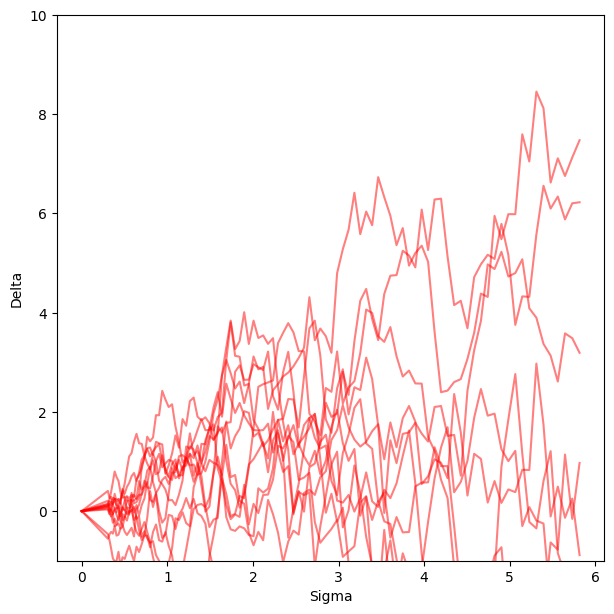

In [3]:
rw.plot_walks(
    redshift=redshift,
    walks=walks,
    mass_steps=mass_steps,
    sigma_steps=sigma_steps,
    n_walks_plot=12,
)

Now that our random walks are set, we define a barrier for halo formation. The simplest choice is the Press-Schechter `d_crit = 1.686/D(z)`

In [ ]:
#Set up the Barrier
barrier_steps = rw.barrier_PS(sigma_steps, growthf)
#or use a more complicated barrier such as Sheth-Tormen
# barrier_steps = rw.barrier_ST(sigma_steps, growthf)

#find at which indices the random walks cross the barrier
crossing_points = rw.get_crossing_points( #get them to write this function too
    delta_arr=walks,
    barrier=barrier_steps,
)

#find the mass and sigma values at those indices, the above function returns -1
#  if the walk never crosses the barrier which we mark as NaN
halo_masses = np.where(crossing_points==-1,np.nan,mass_steps[crossing_points])
halo_sigma = np.where(crossing_points==-1,np.nan,sigma_steps[crossing_points])

Now we plot the random walks with their barrier crossing, which determines the population of halos masses

(<Figure size 600x600 with 3 Axes>,
 array([<Axes: ylabel='N/Nmax'>, <Axes: xlabel='Sigma', ylabel='Delta'>,
        <Axes: xlabel='Mass', ylabel='N/Nmax'>], dtype=object))

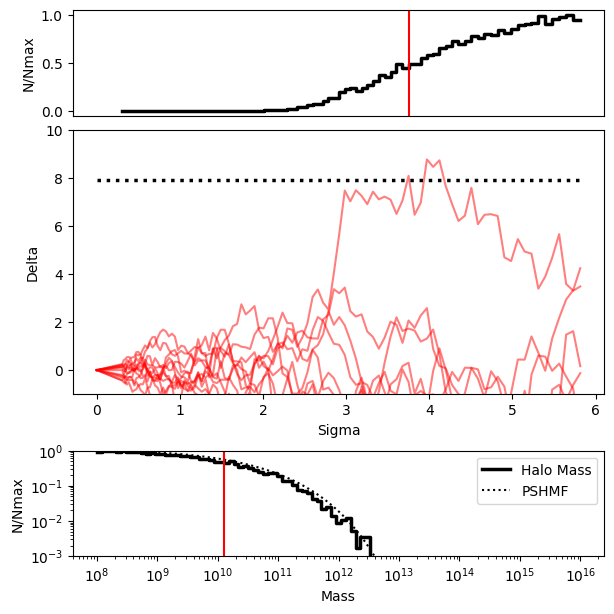

In [6]:
rw.plot_walks(
    walks=walks,
    redshift=redshift,
    mass_steps=mass_steps,
    sigma_steps=sigma_steps,
    barrier=barrier_steps,
    halo_masses=halo_masses,
    halo_sigma=halo_sigma,
    n_walks_plot=12, #change this to plot more or less walks
    hmf_type='PS'
)

Here red vertical lines show the mass/sigma of the randomly selected walks which cross the barrier at some point, and the dotted line in the bottom panel shows the expected Press-Schecter collapsed mass fraction.

Repeating with a different barrier gives us a different set of masses

In [ ]:
#Set up the Barrier
barrier_steps_ST = rw.barrier_ST(sigma_steps, growthf)

#find at which indices the random walks cross the barrier
crossing_points_ST = rw.get_crossing_points( #get them to write this function too
    delta_arr=walks,
    barrier=barrier_steps,
)

#find the mass and sigma values at those indices, the above function returns -1
#  if the walk never crosses the barrier which we mark as NaN
halo_masses_ST = np.where(crossing_points==-1,np.nan,mass_steps[crossing_points])
halo_sigma_ST = np.where(crossing_points==-1,np.nan,sigma_steps[crossing_points])
rw.plot_walks(
    walks=walks,
    redshift=redshift,
    mass_steps=mass_steps,
    sigma_steps=sigma_steps,
    barrier=barrier_steps_ST,
    halo_masses=halo_masses_ST,
    halo_sigma=halo_sigma_ST,
    n_walks_plot=12, #change this to plot more or less walks
    hmf_type='ST'
)

### Conditioning
We can "condition" the above random walks by giving them a region of a certain size or density to begin with

### Simulated Halo Catalogs

21cmfast uses a given HMF (defined originally by random walk models such as the one above) to quickly generate halo populations from an initial conditions grid